## imports

In [1]:
import numpy as np
from numpy import sqrt, abs, pi, exp, diag, mean, min, max, sum, eye
from numpy.linalg import norm, inv
import math
# import scipy
import matplotlib.pyplot as plt
import time

In [2]:
import torch

## function & derivatives

In [3]:
def rastrigin(x):
    d = x.shape[1]
    f = 10*d + np.sum(x**2 - 10*np.cos(2*np.pi*x), axis = 1)
    return f.astype('float32')

In [4]:
def rastrigin_grad(x):
    gradf = 2*x + 10*2*np.pi*np.sin(2*np.pi*x)
    return gradf.astype('float32')

## func, xmean, dim

In [5]:
N = 5000
strfitnessfct = rastrigin
strgrad = rastrigin_grad
xmean = 0.1*np.ones((N,1)) + 0.01* np.random.randn(N,1)

In [6]:
xmean.shape

(5000, 1)

## initialisations

In [7]:
stopfitness = 1e-3

In [8]:
xmean = xmean.astype('float32')
xmin = xmean

In [9]:
R = 0.1 * np.ones((1,N))
Γ = np.zeros((N,1), dtype = np.float32)
p = 5
cs = 0.1
it = 0
prev = 0
θ = 0.1
Δ = 0
x_st = xmean
fXX = (strfitnessfct(xmean.T))

## helper functions

In [10]:
def generate_arx(x, r, num = 5):
    return np.concatenate([x,x + (r * (2*np.random.rand(num-1, x.shape[0])-1)).T], axis = 1)

In [11]:
def sorted_x_y_grad(x, grads = True):
    if grads == True:
        y = strfitnessfct(x.T)
        y_grad = strgrad(x.T).T
        
        y_sorted = np.sort(y)
        sorted_indices = np.argsort(y)
        y_grad_sorted = y_grad[:,sorted_indices]
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]

        return x_sorted, y_sorted[0], y_grad_sorted, fittest
    else:
        y = strfitnessfct(x.T)
        y_sorted = np.sort(y)
        sorted_indices = np.argsort(y)
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]
        worst = x_sorted[:,-1:]

        return fittest, worst, y_sorted[0]

In [12]:
def calc_invH(x, x_grad, γ = 1):
    a = x - np.mean(x, axis = 1).reshape(-1,1)
    b = x_grad - np.mean(x_grad, axis = 1).reshape(-1,1)
    c = np.sum(a*b, axis = 1)
    d = np.sum(b*b, axis = 1)
    Hinv = (c / d).reshape(-1,1)
    Hinv = np.nan_to_num(Hinv)
    Hinv[Hinv<0] = 0.0
    return Hinv**γ

In [13]:
def cal_R(xmin, xmax, ps, cs = 0.1):
    ps = (1 - cs) * ps + cs * (xmax - xmin)
    sig = np.minimum(np.abs(ps.T), 0.01 * np.ones_like(ps.T))
    sig[sig == 0] = 0.01
    return sig, ps

In [14]:
def update_ensemble(x, α, Δ):
    K = Δ
    x1 = x - α * Δ
    return x1, K

In [15]:
def increment(K, B, G, θ=0.9):
    return θ * K + B * G

In [16]:
def wolfe_step(g, Hg, x, loss):
    
    step = 0.1
    c_1 = 0.01
    pvec = - Hg#/ torch.norm(Hg)
    γ = 1.0
    
    while γ > 1e-6:
        new_x = x.reshape(-1,1) + γ * pvec.reshape(-1,1)
        loss_new = strfitnessfct(new_x.T)
        g_new = strgrad(new_x.T)
        min_loss = c_1 * γ * pvec @ g
        armijo = loss_new - loss - min_loss

        if armijo < -0:
            step = γ
            x = new_x.reshape(-1,1)
            break
            
        else:
            γ *= 0.5
        # raise RuntimeError("Backtracking line search failed to converge")

    return step

# FINDER

In [17]:
tic = time.time()
while True:
    
    '''
    sampling around xmean
    '''
    arx = generate_arx(xmin, R)
    '''
    gradient computation and sorting initial ensemble
    '''
    arx_sorted, least_fitness, gradf_sorted, xmiin = sorted_x_y_grad(arx, grads=True)
    
    '''
    diagonal approximation to the stochastic mimic of the inverse Hessian
    '''
    B = calc_invH(arx_sorted, gradf_sorted)
    
    '''
    increment term
    '''
    Δ_sorted = increment(prev, B, gradf_sorted, θ)

    '''
    update ensemble
    '''
    α = wolfe_step(gradf_sorted[:, 0], Δ_sorted[:,0], arx_sorted[:, 0], least_fitness)
    arx_new, prev = update_ensemble(arx_sorted, α, Δ_sorted)
    
    '''
    new ensemble
    '''
    arx_new1 = np.concatenate([arx_new, xmiin], axis = 1)
    
    '''
    search radius update
    '''
    xmin, xmax, min_fitness = sorted_x_y_grad(arx_new1, grads=False)
    R, Γ = cal_R(xmin, xmax, Γ)
    
    '''
    storing varibales for plotting
    '''
    x_st = np.concatenate([x_st, xmin], axis = 1)
    fXX = np.concatenate([fXX, np.array([min_fitness])], axis = 0)
    
    '''
    iteration count update and printing
    '''
    if it == 0:
        print(it, "\t", fXX[it],"\n")
    it += 1
    print(it,"\t", fXX[it],"\n")
    
    '''
    termination criteria
    '''
    if fXX[-1] <= stopfitness:
        break
toc = time.time()
print("finished training in ",toc-tic," seconds")

0 	 9653.004 

1 	 561.98444 

2 	 139.13788 

3 	 2.9703336 

4 	 1.5545315 

5 	 0.02625539 

6 	 0.014603566 

7 	 0.0004762628 

finished training in  0.015663623809814453  seconds


# Adam

In [18]:
from numpy.random import rand
from numpy import sqrt
# xx_st = xmean
fx_st = []
def adam(func, n_iter, alpha, beta1 = 0.9, beta2 = 0.999, eps=1e-8):
    # generate an initial point
    global xx_st
    xx_st = xmean

    x = xmean.copy()  # Initialize with random values
    score = strfitnessfct(x.T)
    # initialize first and second moments
    m = [0.0 for _ in range(len(x))]
    v = [0.0 for _ in range(len(x))]
    # run the gradient descent updates
    for t in range(n_iter):
        # calculate gradient g(t)
        g = strgrad(x.T)
        g = g.T
        # build a solution one variable at a time
        
        for i in range(len(x)):
            # m(t) = beta1 * m(t-1) + (1 - beta1) * g(t)
            m[i] = beta1 * m[i] + (1.0 - beta1) * g[i]
            # v(t) = beta2 * v(t-1) + (1 - beta2) * g(t)^2
            v[i] = beta2 * v[i] + (1.0 - beta2) * g[i]**2
            # mhat(t) = m(t) / (1 - beta1(t))
            mhat = m[i] / (1.0 - beta1**(t+1))
            # vhat(t) = v(t) / (1 - beta2(t))
            vhat = v[i] / (1.0 - beta2**(t+1))
            # x(t) = x(t-1) - alpha * mhat(t) / (sqrt(vhat(t)) + eps)
            x[i] = x[i] - alpha * mhat / (sqrt(vhat) + eps)
        # evaluate candidate point
        score = strfitnessfct(x.T)
        fx_st.append(score)
        xx_st = np.concatenate([xx_st, x], axis = 1)
        # report progress
        print('>%d f() = %.5f' % (t, score))
        if score < 1e-3:
            print("------")
            break
    
    return [x, score, xx_st]


In [19]:
tic = time.time()
_, f, xx_st_001 = adam(6, 2000, 1e-3)
toc = time.time()
print(toc - tic)

/tmp/ipykernel_3605898/1520024854.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('>%d f() = %.5f' % (t, score))


>0 f() = 9468.75000
>1 f() = 9286.15625
>2 f() = 9105.25391
>3 f() = 8926.07422
>4 f() = 8748.64844
>5 f() = 8573.02344
>6 f() = 8399.21484
>7 f() = 8227.26172
>8 f() = 8057.19141
>9 f() = 7889.03125
>10 f() = 7722.81250
>11 f() = 7558.55469
>12 f() = 7396.28906
>13 f() = 7236.03516
>14 f() = 7077.81250
>15 f() = 6921.64453
>16 f() = 6767.55469
>17 f() = 6615.54297
>18 f() = 6465.64062
>19 f() = 6317.85156
>20 f() = 6172.19531
>21 f() = 6028.67969
>22 f() = 5887.31250
>23 f() = 5748.10156
>24 f() = 5611.05469
>25 f() = 5476.17188
>26 f() = 5343.45703
>27 f() = 5212.91406
>28 f() = 5084.54297
>29 f() = 4958.33984
>30 f() = 4834.30469
>31 f() = 4712.42969
>32 f() = 4592.70703
>33 f() = 4475.14062
>34 f() = 4359.71094
>35 f() = 4246.41406
>36 f() = 4135.23828
>37 f() = 4026.17578
>38 f() = 3919.21094
>39 f() = 3814.32812
>40 f() = 3711.51562
>41 f() = 3610.75781
>42 f() = 3512.03906
>43 f() = 3415.33984
>44 f() = 3320.64844
>45 f() = 3227.93750
>46 f() = 3137.19531
>47 f() = 3048.39844
>4

# plotting

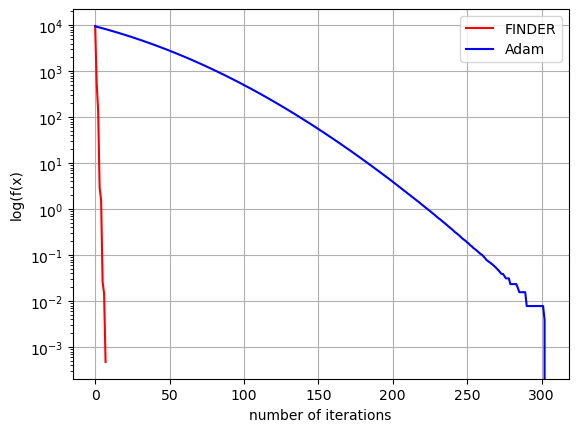

In [20]:
plt.style.use('default')
plt.plot(fXX,'r', label = 'FINDER')
plt.plot(fx_st,'b', label='Adam')
plt.yscale('log')
plt.legend()
plt.xlabel("number of iterations")
plt.ylabel("log(f(x)")
plt.grid()
plt.show()